In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from vistaformer.models import get_model
from vistaformer.config import get_model_config
from vistaformer.train_and_evaluate.eval_utils import generate_test_metrics
from vistaformer.datasets.pastis.dataloader import get_dataloader
# from vistaformer.datasets.mtlcc.dataloader import get_dataloader


num_params = lambda x: sum(p.numel() for p in x.parameters() if p.requires_grad)

device = "cuda:1" if torch.cuda.is_available() else "cpu"

config_path = Path("/very-real-path-to-config.yml")
out_path = Path("./output")
if not out_path.exists():
    out_path.mkdir(parents=True)

config = get_model_config(config_path)

model = get_model(config)
model = model.to(device)

weights = torch.load("/very-real-path-to/best_model.pth", map_location=device)
model.load_state_dict(weights["model_state_dict"])

model = model.eval()

print(f"Number of trainable parameters: {num_params(model)}")

dataloader = get_dataloader(config, fold=config.dataset.kwargs.get("test_folds"))

Number of trainable parameters: 1251668


In [2]:
generate_test_metrics(
    model=model,
    dataloader=dataloader,
    num_classes=config.num_classes,
    device=device,
    output_path=out_path,
    ignore_index=config.ignore_index,
)

Generating test metrics for 20 classes...
Number of rows that have accuracy greater than 0: 19
Saving metrics to output/test_metrics.csv
Head of metrics:
                                 F1  Accuracy Precision    Recall       IoU
background                 0.852962  0.867966  0.838468  0.867966  0.743622
meadow                     0.782378  0.764331  0.801298  0.764331  0.642546
soft-winter-wheat          0.927643  0.927224  0.928062  0.927224   0.86505
corn                       0.921349   0.93893  0.904415   0.93893  0.854168
winter-barley              0.892498  0.902103  0.883095  0.902103  0.805865
winter-rapeseed            0.937384  0.932061  0.942768  0.932061  0.882147
spring-barley               0.77938  0.770594  0.788369  0.770594  0.638511
sunflower                  0.836032  0.848425  0.823995  0.848425   0.71826
grapevine                  0.734068  0.773642  0.698345  0.773642  0.579863
beet                       0.922145  0.926458  0.917873  0.926458  0.855538
winter-tri

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap

def set_colormap():
    cm = matplotlib.colormaps.get_cmap("tab20")
    def_colors = cm.colors
    cus_colors = ["k"] + [def_colors[i] for i in range(1, 19)] + ["w"]
    cmap = ListedColormap(colors=cus_colors, name="agri", N=20)

    return cmap

def get_rgb(input: torch.Tensor, b: int, t: int) -> np.ndarray:
    """
    Get the RGB image from the input tensor.

    Function Retrieved from U-TAE codebase.
    Repo Link: https://github.com/VSainteuf/utae-paps
    """
    im = input[b, t, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)

    return im

def get_mask_pred(pred: torch.Tensor, ground_truth: torch.Tensor, b: int) -> np.ndarray:
    """
    """
    mask = pred[b].cpu().numpy()

    return mask


def display_preds_with_mask(inputs: torch.Tensor, labels: torch.Tensor, preds: torch.Tensor, timestep: int, cmap: ListedColormap):
    """
    Function is designed to display the predictions of the model alongside the ground truth mask.

    Note that this function is designed to work with the PASTIS dataset, but could easily be adapted to work for other
    datasets as well
    """

    batch_size = inputs.shape[0]
    display_res = 5
    fig, axes = plt.subplots(batch_size, 6, figsize=(4 * display_res, batch_size * display_res))
    axes[0, 0].set_title(f"One S2 Image ({timestep})")
    axes[0, 1].set_title(f"One S2 Image ({timestep + 1})")
    axes[0, 2].set_title(f"One S2 Image ({timestep + 2})")
    axes[0, 3].set_title(f"One S2 Image ({timestep + 3})")
    axes[0, 4].set_title("Ground Truth Mask")
    axes[0, 5].set_title("Predicted Mask")

    for i in range(batch_size):
        axes[i, 0].imshow(get_rgb(inputs, i, timestep))
        axes[i, 1].imshow(get_rgb(inputs, i, timestep + 1))
        axes[i, 2].imshow(get_rgb(inputs, i, timestep + 2))
        axes[i, 3].imshow(get_rgb(inputs, i, timestep + 3))
        axes[i, 4].imshow(labels[i].cpu().numpy(), cmap=cmap, vmin=0, vmax=19)
        axes[i, 5].imshow(get_mask_pred(preds, labels, i), cmap=cmap, vmin=0, vmax=19)

        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
        axes[i, 2].axis("off")
        axes[i, 3].axis("off")
        axes[i, 4].axis("off")
        axes[i, 5].axis("off")

    plt.show()

cmap = set_colormap()

In [6]:
attn_l1, attn_l2, attn_l3 = [], [], []

def get_l1_attens(module, input, output):
    global attn_l1
    attn_l1.append(output)

def get_l2_attens(module, input, output):
    global attn_l2
    attn_l2.append(output)

def get_l3_attens(module, input, output):
    global attn_l3
    attn_l3.append(output)

for layer in model.backbone.transformers[0].layers:
    layer[0].register_forward_hook(get_l1_attens)

for layer in model.backbone.transformers[1].layers:
    layer[0].register_forward_hook(get_l2_attens)

for layer in model.backbone.transformers[2].layers:
    layer[0].register_forward_hook(get_l3_attens)


In [7]:
inputs, labels = next(iter(dataloader))
outputs = model(inputs.to(device))
outputs = outputs.argmax(dim=1)

In [8]:
def get_attn_maps(attn_maps, model, upsample_i, b, t, c, h, w):
    """
    """
    attns = []
    for attn in attn_maps:
        maps = attn.reshape(b, t, h, w, c).permute(0, 4, 1, 2, 3).contiguous()
        maps = model.head.upsample[upsample_i](maps)
        attns.append(maps.mean(dim=1).cpu().detach().numpy())

    return sum(attns) / len(attns)


l1_attns = get_attn_maps(attn_l1, model, 0, 32, 60, 32, 16, 16)
l2_attns = get_attn_maps(attn_l2, model, 1, 32, 30, 64, 8, 8)
l3_attns = get_attn_maps(attn_l3, model, 2, 32, 15, 128, 4, 4)
l1_attns.shape, l2_attns.shape, l3_attns.shape

((32, 60, 32, 32), (32, 30, 32, 32), (32, 15, 32, 32))

In [9]:
class MCDropoutModel(nn.Module):
    def __init__(self, original_model):
        super(MCDropoutModel, self).__init__()
        self.original_model = original_model

    def forward(self, x):
        return self.original_model(x)

    def enable_dropout(self):
        def apply_dropout(m):
            if isinstance(m, nn.Dropout):
                m.train()
        self.apply(apply_dropout)

def mc_dropout_predictions(model, input_tensor, num_samples=50):
    model.enable_dropout()
    predictions = []
    with torch.no_grad():
        for _ in range(num_samples):
            output = model(input_tensor)
            predictions.append(output.unsqueeze(0))
    predictions = torch.cat(predictions, dim=0)

    return predictions

def compute_uncertainty(predictions):
    mean_prediction = torch.mean(predictions, dim=0)
    variance_prediction = torch.var(predictions, dim=0)
    return mean_prediction, variance_prediction

def generate_uncertainty_map(variance_prediction):
    uncertainty_map = torch.mean(variance_prediction, dim=1)
    return uncertainty_map

mc_model = MCDropoutModel(model)
mc_model = mc_model.to(device)

predictions = mc_dropout_predictions(mc_model, inputs.to(device), num_samples=10)
mean_prediction, variance_prediction = compute_uncertainty(predictions)
uncertainty_map = generate_uncertainty_map(variance_prediction)

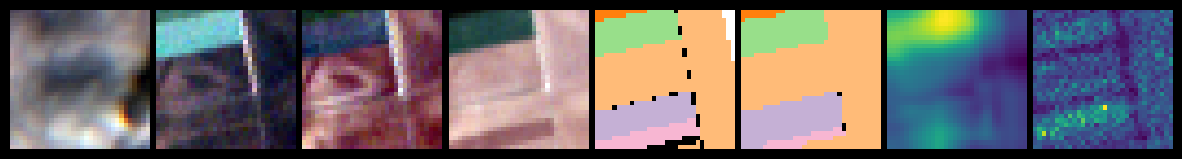

In [20]:
def softmax(x):
    return(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())

def display_attn_maps(attention_maps, inputs, mask, pred_mask, uncertainty_mask, b = 0, t = 0):
    """
    Display the attention maps overlayed on the RGB image.

    Parameters:
        - attention_maps: List of attention maps.
        - rgb_image: RGB image of shape (H, W, 3).
    """
    num_maps = len(attention_maps)
    # fig, axes = plt.subplots(1, num_maps + 4, figsize=(5 * (num_maps + 4), 5))
    fig, axes = plt.subplots(1, 8, figsize=(15, 8))
    axes[0].imshow(get_rgb(inputs, b, t))
    axes[0].axis("off")
    axes[1].imshow(get_rgb(inputs, b, t+1))
    axes[1].axis("off")
    axes[2].imshow(get_rgb(inputs, b, t+2))
    axes[2].axis("off")
    axes[3].imshow(get_rgb(inputs, b, t+3))
    axes[3].axis("off")
    axes[4].imshow(mask, cmap=cmap, vmin=0, vmax=19)
    axes[4].axis("off")
    axes[5].imshow(pred_mask, cmap=cmap, vmin=0, vmax=19)
    axes[5].axis("off")
    axes[6].imshow(softmax(np.mean(np.array(attention_maps), axis=0)))
    axes[6].axis("off")
    axes[7].imshow(uncertainty_mask)
    axes[7].axis("off")

    fig.subplots_adjust(wspace = 0.05)

    # for i, attn_map in enumerate(attention_maps):
    #     # overlayed_image = overlay_attention_on_image(rgb_image, attn_map)
    #     axes[i + 4].imshow(attn_map)
    #     axes[i + 4].axis("off")

    plt.show()


i = 0
b = 0
display_attn_maps([np.mean(l1_attns[b], axis=0),np.mean(l2_attns[b], axis=0), np.mean(l3_attns[b], axis=0)], inputs, labels[b].cpu().numpy(), outputs[b].cpu().numpy(), uncertainty_map[b].cpu().detach().numpy())

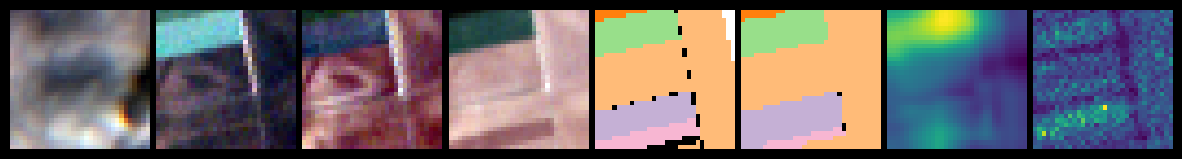

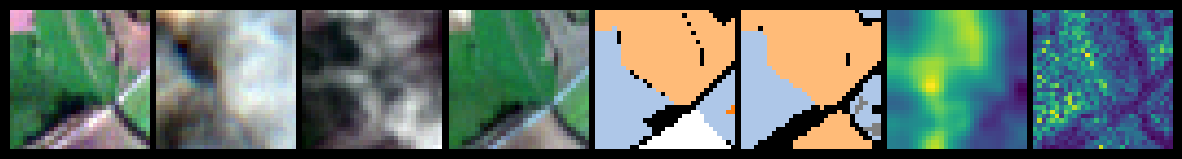

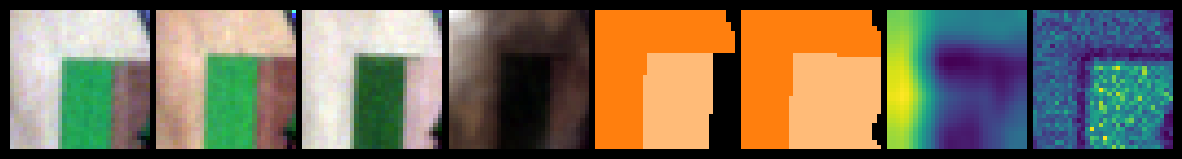

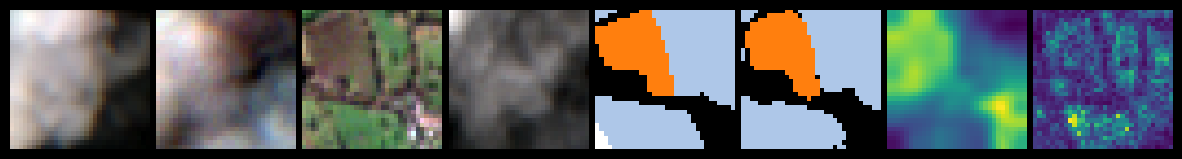

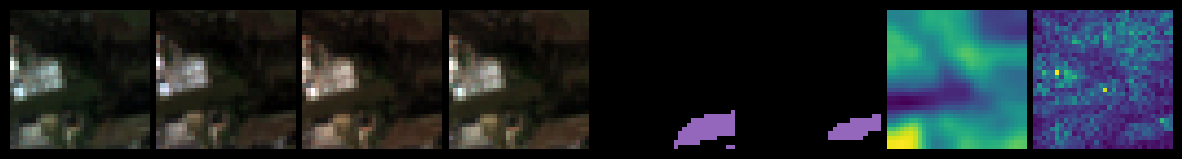

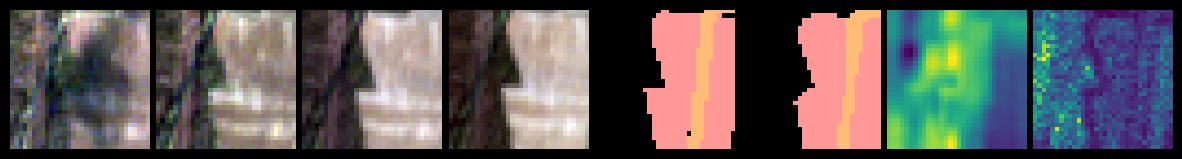

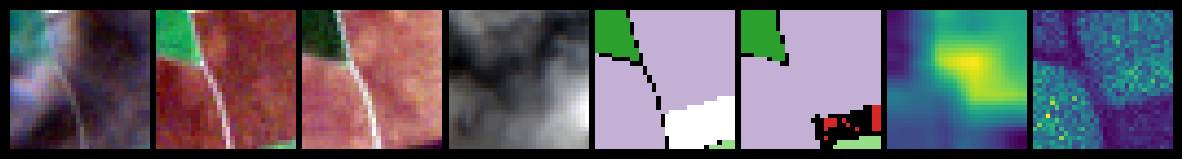

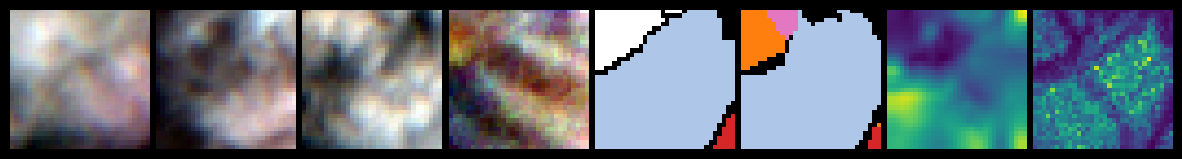

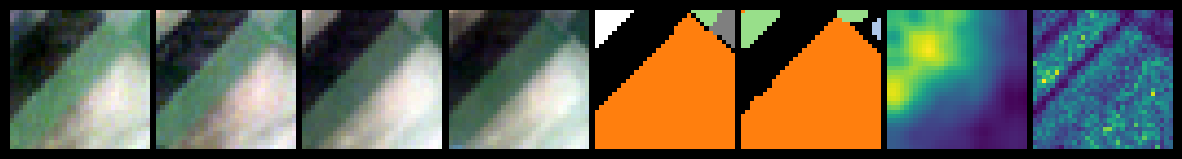

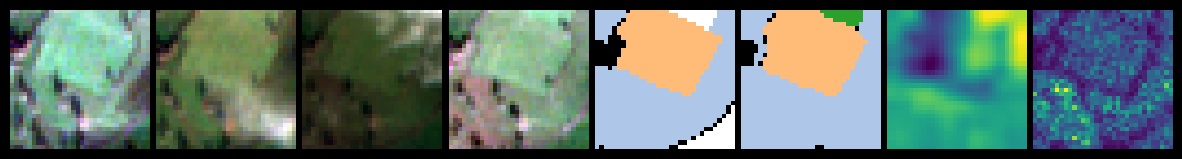

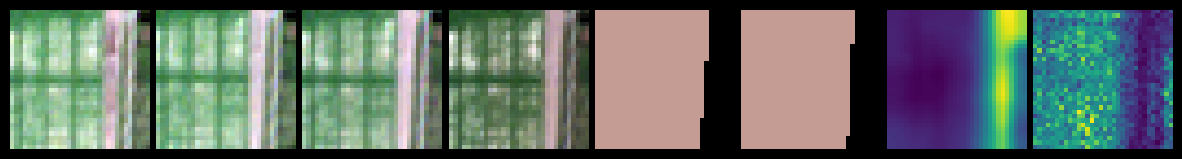

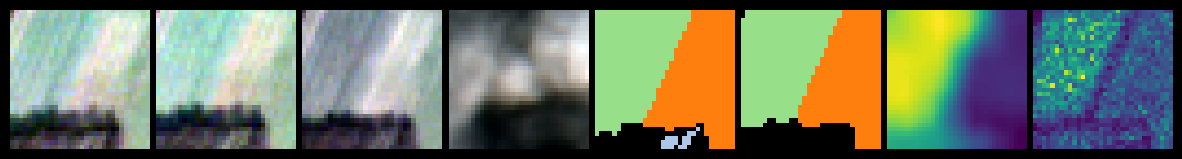

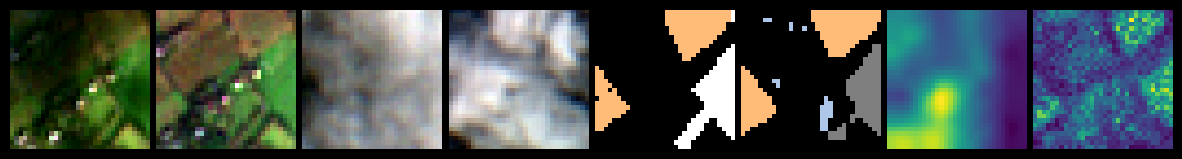

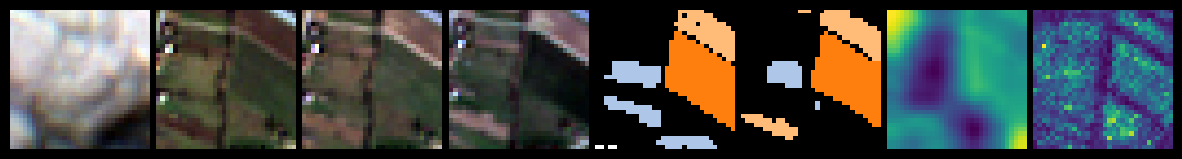

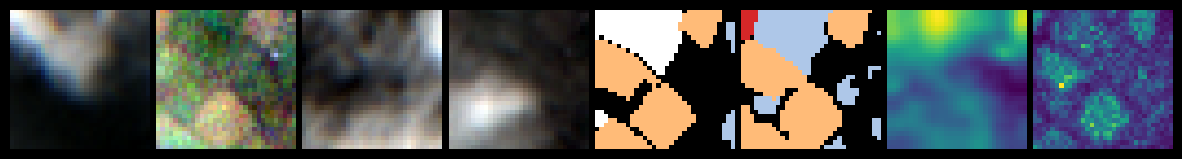

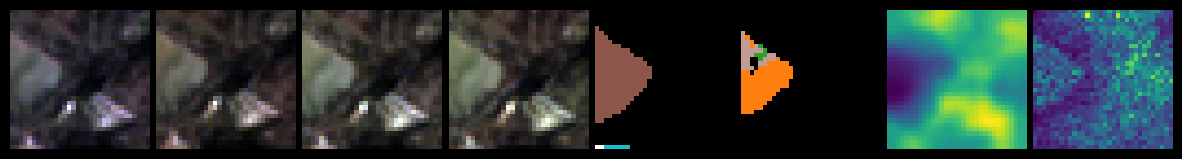

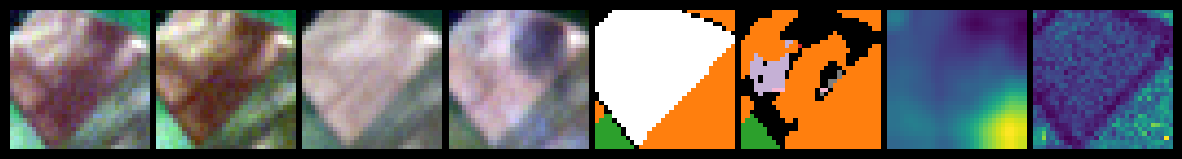

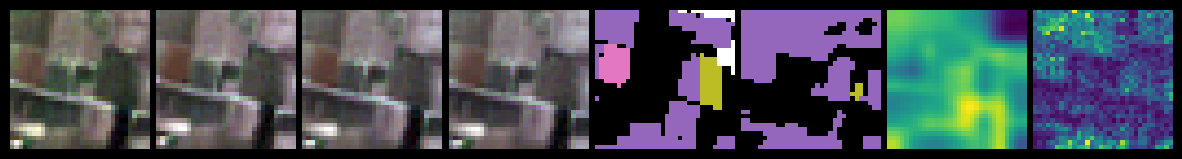

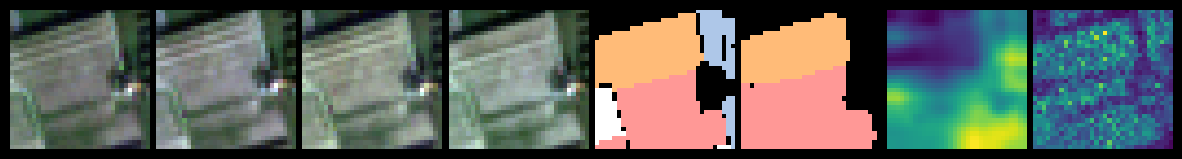

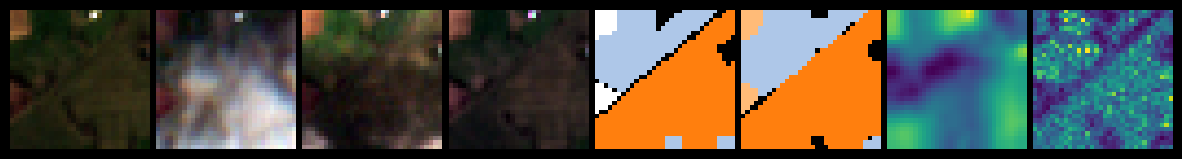

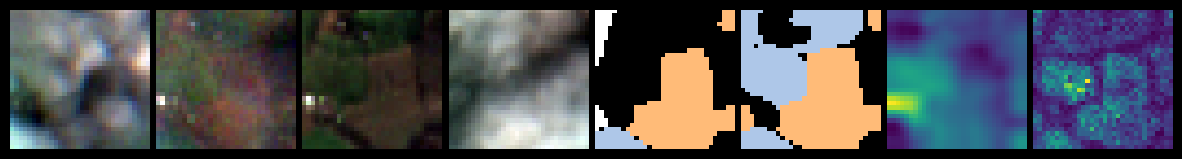

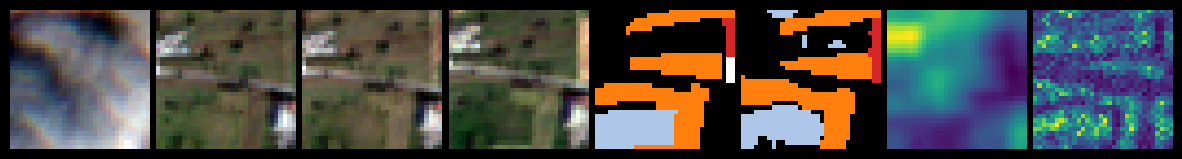

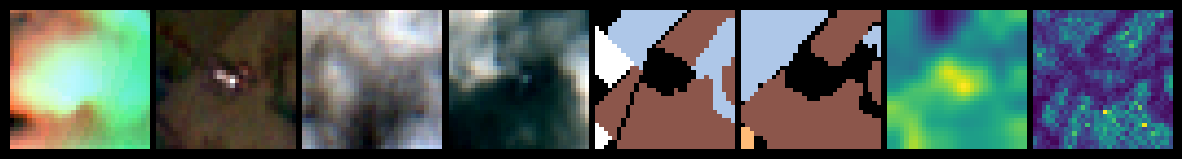

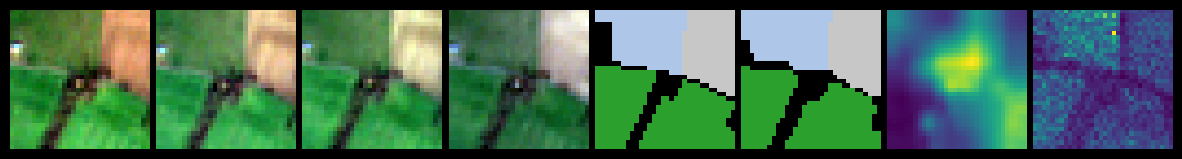

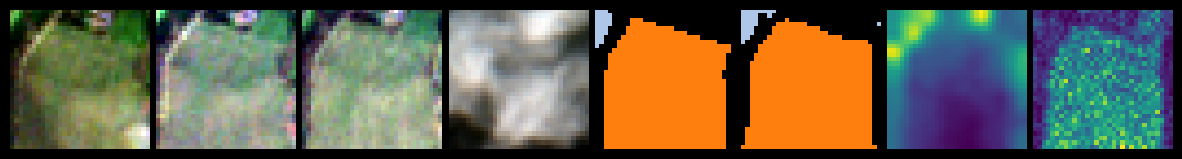

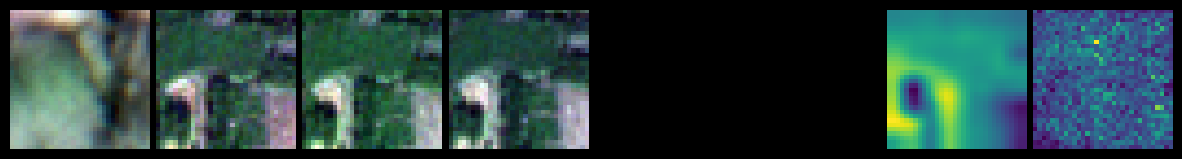

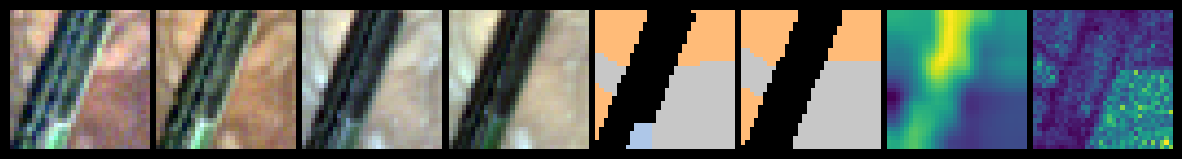

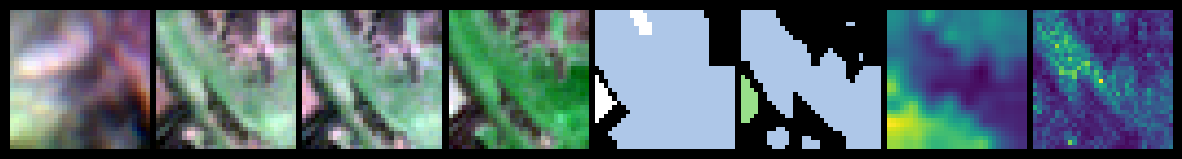

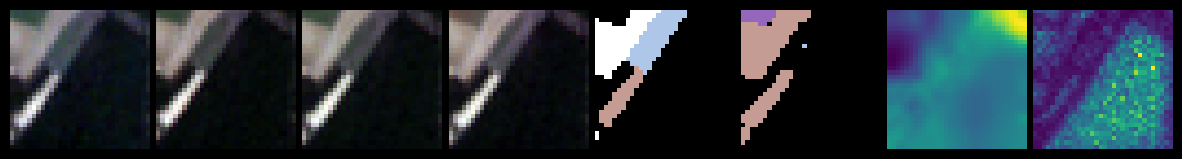

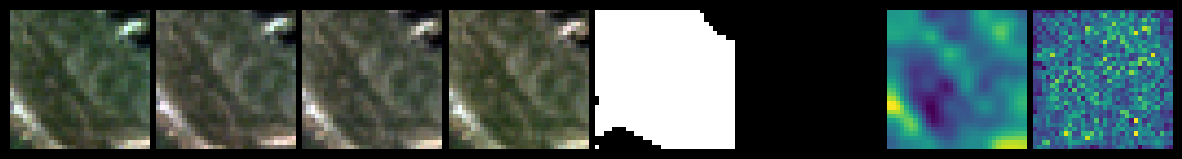

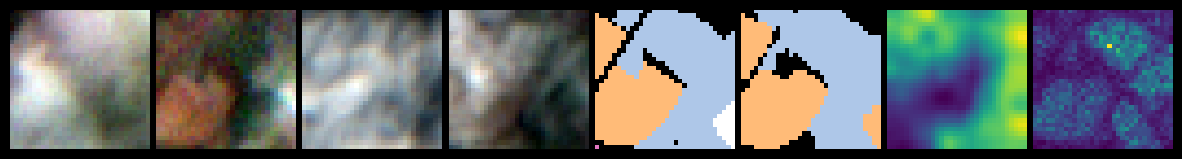

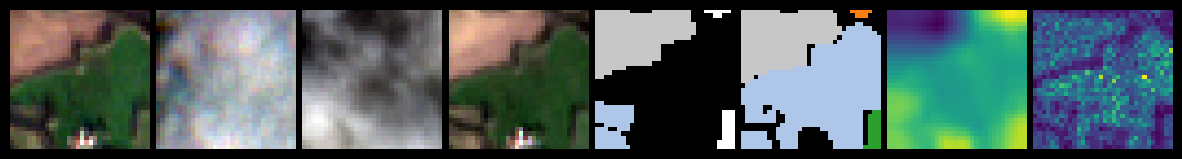

In [21]:
for b in range(inputs.shape[0]):
    display_attn_maps(
        [np.mean(l1_attns[b], axis=0),np.mean(l2_attns[b], axis=0), np.mean(l3_attns[b], axis=0)],
        inputs,
        labels[b].cpu().numpy(),
        outputs[b].cpu().numpy(),
        uncertainty_map[b].cpu().detach().numpy(),
        b=b
    )